### Реализация алгоритма kNN<a class='anchor' id='implement_knn'>

In [34]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import warnings
warnings.filterwarnings('ignore')

Загрузим один из "игрушечных" датасетов из sklearn.

In [35]:
X, y = load_iris(return_X_y=True)

# Для наглядности возьмем только первые два признака (всего в датасете их 4)
X = X[:, :2]

Разделим выборку на обучающую и тестовую

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=1,
                                                    stratify=y)
X_train.shape, X_test.shape

((120, 2), (30, 2))

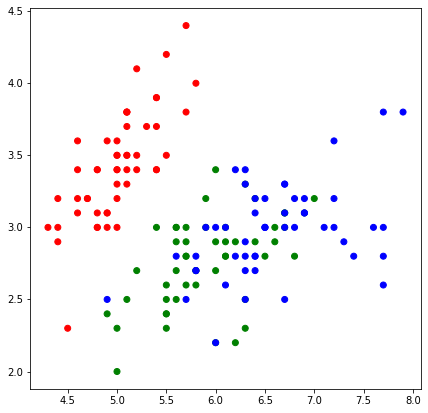

In [37]:
cmap = ListedColormap(['red', 'green', 'blue'])
plt.figure(figsize=(7, 7))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap);

Используем евклидову метрику. Реализуем функцию для ее подсчета.

In [38]:
def e_metrics(x1, x2):
    
    distance = np.sum(np.square(x1 - x2))

    return np.sqrt(distance)

Реализуем алгоритм поиска k ближайших соседей.

In [39]:
# {class_item: 0 for class_item in set(y_train)}

In [40]:
def knn(x_train, y_train, x_test, k):
    
    answers = []
    for x in x_test:
        test_distances = []
            
        for i in range(len(x_train)):
            
            # расчет расстояния от классифицируемого объекта до
            # объекта обучающей выборки
            distance = e_metrics(x, x_train[i])
            
            # Записываем в список значение расстояния и ответа на объекте обучающей выборки
            test_distances.append((distance, y_train[i]))
        
        # создаем словарь со всеми возможными классами
        classes = {class_item: 0 for class_item in set(y_train)}
        
        # Сортируем список и среди первых k элементов подсчитаем частоту появления разных классов
        for d in sorted(test_distances)[0:k]:
            classes[d[1]] += 1

        # Записываем в список ответов наиболее часто встречающийся класс
        answers.append(sorted(classes, key=classes.get)[-1])
        
    return answers

Напишем функцию для вычисления точности

In [41]:
def accuracy(pred, y):
    return (sum(pred == y) / len(y))

## Домашнее задание<a class='anchor' id='hw'>

__1. К алгоритму kNN, реализованному на уроке, реализовать добавление весов для соседей по любому из показанных на уроке принципов.__

In [42]:
def new_knn(x_train, y_train, x_test, k, weights=None):
    
    answers = []
    for x in x_test:
        test_distances = []
            
        for i in range(len(x_train)):
            
            # расчет расстояния от классифицируемого объекта до
            # объекта обучающей выборки
            distance = e_metrics(x, x_train[i])
            
            # Записываем в список значение расстояния и ответа на объекте обучающей выборки
            test_distances.append((distance, y_train[i]))
        
        # создаем словарь со всеми возможными классами
        classes = {class_item: 0 for class_item in set(y_train)}
        
        # Сортируем список и среди первых k элементов подсчитаем частоту появления разных классов
        for i, d in enumerate(sorted(test_distances)[0:k]):
            w = weights(i, d[0]) if weights else 1
            
            classes[d[1]] += w

        # Записываем в список ответов наиболее часто встречающийся класс
        answers.append(sorted(classes, key=classes.get)[-1])
        
    return answers

Принцип добавления соседям весов от расстояния $d$ веса:
- $w(d) = q^{d}$,   $q \in (0,1)$;

In [43]:
def neighbor_weights(i, d):
    q = 0.2
    return q ** d

In [44]:
k = 10

y_pred = new_knn(X_train, y_train, X_test, k, neighbor_weights)

print(f'Точность алгоритма при k = {k}: {accuracy(y_pred, y_test):.3f}')

Точность алгоритма при k = 10: 0.733


__2. *Написать функцию подсчета метрики качества кластеризации как среднее квадратичное внутрикластерное расстояние и построить график ее зависимости от количества кластеров k (взять от 1 до 10) для выборки данных из данного урока (создать датасет, как в методичке).__

In [45]:
def kmeans(data, k, max_iterations, min_distance):
    # Создадим словарь для классификации
    classes = {i: [] for i in range(k)}
    
    # инициализируем центроиды как первые k элементов датасета
    centroids = [data[i] for i in range(k)]
    
    for _ in range(max_iterations):
        # классифицируем объекты по центроидам
        for x in data:
            # определим расстояния от объекта до каждого центроида
            distances = [e_metrics(x, centroid) for centroid in centroids]
            # отнесем объект к кластеру, до центроида которого наименьшее расстояние
            classification = distances.index(min(distances))
            classes[classification].append(x)
        
        # сохраним предыдущие центроиды в отдельный список для последующего сравнения сновыми
        old_centroids = centroids.copy()
        
        # пересчитаем центроиды как среднее по кластерам
        for classification in classes:
            centroids[classification] = np.average(classes[classification], axis=0)
            
        # сравним величину смещения центроидов с минимальной
        optimal = True
        for centroid in range(len(centroids)):
            if np.sum(abs((centroids[centroid] - old_centroids[centroid]) / old_centroids * 100)) > min_distance:
                optimal = False
                
        # если все смещения меньше минимального, останавливаем алгоритм  
        if optimal:
            break

    
    return old_centroids, classes

In [46]:
def kmeans_quality(centroids, clusters):
    k = 0
    quality = 0
        
    for c in centroids:
        
        for x in clusters[k]:
            quality += e_metrics(x, c)**2
        k+=1
        
        return quality

In [47]:
def visualize(centroids, classes):
    colors = ['r', 'g', 'b']
    
    plt.figure(figsize=(7,7))
    
    # нанесем на график центроиды
    for centroid in centroids:
        plt.scatter(centroid[0], centroid[1], marker='x', s=130, c='black')
        
    # нанесем объекты раскрашенные по классам
    for class_item in classes:
        for x in classes[class_item]:
            plt.scatter(x[0], x[1], color=colors[class_item])
            
    plt.show()

In [48]:
# определим максимальное количество итераций
max_iterations = 10

# и минимальное расстояние между центроидами до пересчета и после него, при котором нужно остановить алгоритм
min_distance = 1e-4

# сразу определим известное нам количество кластеров
k = 3

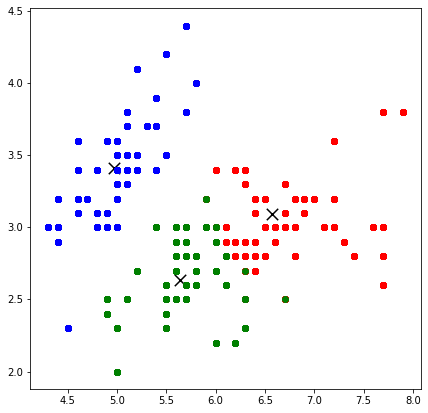

In [49]:
centroids, clusters = kmeans(X, k, max_iterations, min_distance)

visualize(centroids, clusters)

In [50]:
kmeans_q = []

for k in range(1, 11):
    centroids, clusters = kmeans(X, k, max_iterations, min_distance)
    kmeans_q.append(kmeans_quality(centroids, clusters))

In [51]:
print('Cреднее квадратичные внутриклассовые расстояния:\n', np.round(kmeans_q))

Cреднее квадратичные внутриклассовые расстояния:
 [261. 354. 278. 253. 212.  30.  32.  34.  31.  31.]


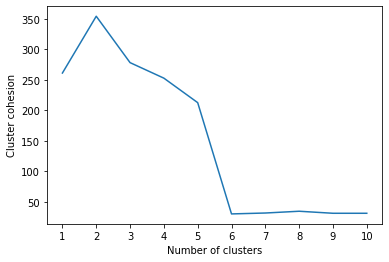

In [52]:
k = np.arange(10)
plt.xlabel('Number of clusters')
plt.xticks(k+1)
plt.ylabel('Cluster cohesion')
plt.plot(k+1, kmeans_q)

Видно, что при увеличении количества кластеров среднее квадратичное внутриклассовое расстояние постепенно уменьшается, снижается также и его изменение